In [ ]:
import os
from google.colab import files

# Upload kaggle.json file
files.upload()

# Set up Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



Saving kaggle (1).json to kaggle (1).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!mv "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d ninadaithal/imagesoasis
!unzip imagesoasis.zip -d "/content/oasis_dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: /content/oasis_dataset/Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: /content/oasis_dataset/Data/Very mil

In [ ]:
data_dir = "/content/oasis_dataset/Data"


In [ ]:
import os

# Recursively list files in the Data folder
for root, dirs, files in os.walk("/content/oasis_dataset/Data"):
    if files:  # Only print directories with files
        print(f"📁 Directory: {root}")
        print(f"   📄 Files: {files[:5]}")  # Display first 5 files for each directory
        print()


📁 Directory: /content/oasis_dataset/Data/Moderate Dementia
   📄 Files: ['OAS1_0351_MR1_mpr-4_117.jpg', 'OAS1_0308_MR1_mpr-4_145.jpg', 'OAS1_0351_MR1_mpr-3_118.jpg', 'OAS1_0351_MR1_mpr-4_143.jpg', 'OAS1_0351_MR1_mpr-3_152.jpg']

📁 Directory: /content/oasis_dataset/Data/Very mild Dementia
   📄 Files: ['OAS1_0380_MR1_mpr-2_105.jpg', 'OAS1_0015_MR1_mpr-2_102.jpg', 'OAS1_0066_MR1_mpr-2_106.jpg', 'OAS1_0243_MR1_mpr-3_137.jpg', 'OAS1_0016_MR1_mpr-2_120.jpg']

📁 Directory: /content/oasis_dataset/Data/Mild Dementia
   📄 Files: ['OAS1_0031_MR1_mpr-3_130.jpg', 'OAS1_0373_MR1_mpr-2_134.jpg', 'OAS1_0052_MR1_mpr-3_118.jpg', 'OAS1_0122_MR1_mpr-3_123.jpg', 'OAS1_0134_MR1_mpr-4_116.jpg']

📁 Directory: /content/oasis_dataset/Data/Non Demented
   📄 Files: ['OAS1_0227_MR1_mpr-1_118.jpg', 'OAS1_0117_MR2_mpr-3_144.jpg', 'OAS1_0241_MR1_mpr-2_156.jpg', 'OAS1_0038_MR1_mpr-3_123.jpg', 'OAS1_0253_MR1_mpr-4_104.jpg']



# preprocessing

In [ ]:
import os
import random
import shutil

# Parameters
sample_size_per_class = 20000  # Change this to however many images per class you want
original_dir = "/content/oasis_dataset/Data"
sample_dir = "/content/oasis_dataset/sample_data"

# Create the sample directory
os.makedirs(sample_dir, exist_ok=True)

# Loop over each class
for class_dir in os.listdir(original_dir):
    class_path = os.path.join(original_dir, class_dir)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)

    # Pick the minimum between sample size and available images
    num_to_sample = min(sample_size_per_class, len(images))
    sample_images = random.sample(images, num_to_sample)

    class_sample_dir = os.path.join(sample_dir, class_dir)
    os.makedirs(class_sample_dir, exist_ok=True)

    for image in sample_images:
        src = os.path.join(class_path, image)
        dst = os.path.join(class_sample_dir, image)
        shutil.copy(src, dst)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
img_height, img_width = 128, 128  # Adjust image size if needed
batch_size = 32

# Set up ImageDataGenerator for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=40,     # Random rotations
    width_shift_range=0.2, # Random horizontal shifts
    height_shift_range=0.2,# Random vertical shifts
    shear_range=0.2,       # Shear transformations
    zoom_range=0.2,        # Zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'    # Fill pixels after transformations
)

# Training data generator (point to the sample directory)
train_gen = datagen.flow_from_directory(
    sample_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use the 80% for training
)

# Validation data generator (point to the sample directory)
val_gen = datagen.flow_from_directory(
    sample_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use the 20% for validation
)

# Retrieve class indices for model interpretation
class_indices = train_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}


Found 31373 images belonging to 4 classes.
Found 7842 images belonging to 4 classes.


# model 3 two conv layers 3 pooling layers and 3 fully conected layers

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
#model3  two convolutional layers, 3 pooling layers, and three fully connected layers
input_tensor = layers.Input(shape=(img_height, img_width, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)

x = layers.Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)


x = layers.Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)


x = layers.Dense(32, activation='relu')(x)
x = Dropout(0.5)(x)


output_tensor = layers.Dense(len(class_indices), activation='softmax')(x)


model = Model(inputs=input_tensor, outputs=output_tensor)


model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,298,148 (16.40 MB)

 Trainable params: 4,298,148 (16.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 204s 200ms/step - accuracy: 0.4682 - loss: 1.1237 - val_accuracy: 0.5505 - val_loss: 0.8953
Epoch 2/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 194s 198ms/step - accuracy: 0.5641 - loss: 0.9137 - val_accuracy: 0.6139 - val_loss: 0.8157
Epoch 3/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 189s 193ms/step - accuracy: 0.6330 - loss: 0.8306 - val_accuracy: 0.6072 - val_loss: 0.7974
Epoch 4/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 192s 196ms/step - accuracy: 0.6420 - loss: 0.8066 - val_accuracy: 0.6231 - val_loss: 0.7920
Epoch 5/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 191s 195ms/step - accuracy: 0.6536 - loss: 0.7854 - val_accuracy: 0.6191 - val_loss: 0.7880
Epoch 6/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 189s 193ms/step - accuracy: 0.6661 - loss: 0.7635 - val_accuracy: 0.6256 - val_loss: 0.7968
Epoch 7/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 189s 192ms/step - accuracy: 0.6687 - loss: 0.7565 - val_accuracy: 0.6407 - val_loss: 0.7649
Epoch 8/10
981/981 ━━━━━━━━━━━━━━━━━━━━ 202s 192ms/step - accuracy: 0.6694 -

# evaluation

In [ ]:
loss, accuracy = model.evaluate(val_gen)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

246/246 ━━━━━━━━━━━━━━━━━━━━ 37s 150ms/step - accuracy: 0.6688 - loss: 0.7504
Validation Loss: 0.7454
Validation Accuracy: 0.6688


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = val_gen.classes
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

class_labels = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


246/246 ━━━━━━━━━━━━━━━━━━━━ 37s 148ms/step
                    precision    recall  f1-score   support

     Mild Dementia       0.00      0.00      0.00      1000
 Moderate Dementia       0.00      0.00      0.00        97
      Non Demented       0.51      0.43      0.47      4000
Very mild Dementia       0.34      0.56      0.43      2745

          accuracy                           0.42      7842
         macro avg       0.21      0.25      0.22      7842
      weighted avg       0.38      0.42      0.39      7842

Confusion Matrix:
 [[   0    0  390  610]
 [   0    0   45   52]
 [   0    0 1710 2290]
 [   0    0 1196 1549]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# explainability techniques

In [ ]:
!pip install lime shap
import numpy as np
from lime import lime_image
from tensorflow.keras.preprocessing import image
from skimage import transform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=aa487bb70415073ca411a758d7a63fdb8f5da23d660c1c5c9c6954bf76d90207
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


Lime

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

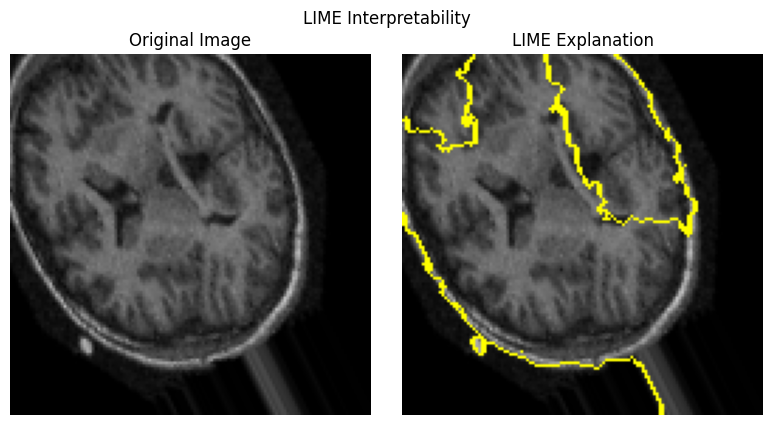

In [ ]:
val_images, val_labels = next(val_gen)
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
explainer = lime_image.LimeImageExplainer()


image = val_images[0]


def predict_fn(images):
    return model.predict(images)

# Explain the prediction
explanation = explainer.explain_instance(
    image.astype('double'),
    classifier_fn=predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)


temp, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    hide_rest=False,
    num_features=5,
    min_weight=0.0
)


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.tight_layout()
plt.suptitle("LIME Interpretability", y=1.05)
plt.show()


Shap

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(32, 128, 128, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(64, 128, 128, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 128, 128, 3

Shape of shap_values: 1, (128, 128, 3, 4)


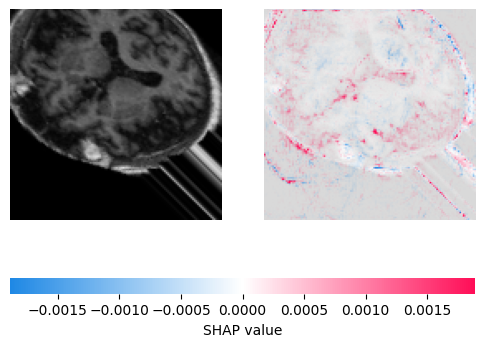

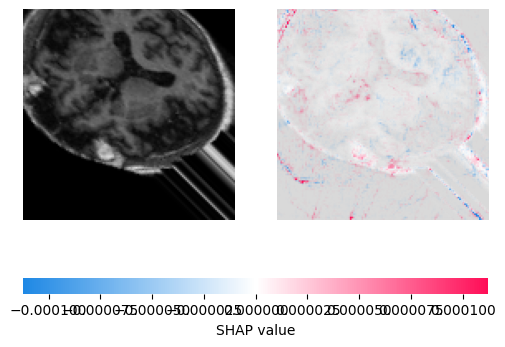

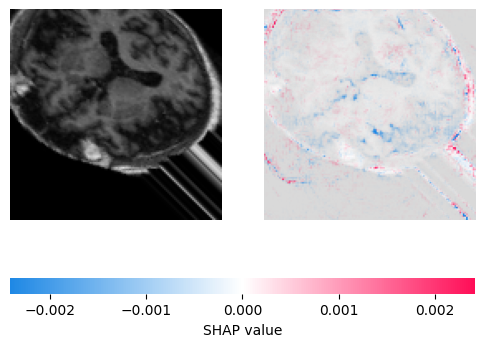

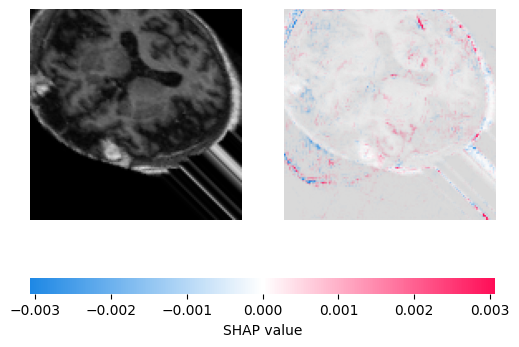

In [ ]:
import shap
import numpy as np

image_batch, label_batch =next(val_gen)

image_idx = np.random.randint(0, len(image_batch))
image_to_explain = image_batch[image_idx]

explainer = shap.DeepExplainer(model, image_batch[:100])

shap_values = explainer.shap_values(image_to_explain.reshape(1, img_height, img_width, 3))

print(f"Shape of shap_values: {len(shap_values)}, {shap_values[0].shape if len(shap_values) > 0 else 'None'}")


if len(shap_values) > 0:
    for class_idx in range(shap_values[0].shape[-1]):
        shap.image_plot([shap_values[0][:, :, :, class_idx]], image_to_explain)
else:
    print("No SHAP values available for visualization.")


In [ ]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_layer
1 conv2d
2 max_pooling2d
3 conv2d_1
4 max_pooling2d_1
5 conv2d_2
6 max_pooling2d_2
7 flatten
8 dense
9 dense_1
10 dense_2
11 dense_3


Grad-Cam

In [ ]:
input_image = image_to_explain[0]
if input_image.shape[-1] == 1:
    input_image = np.repeat(input_image, 3, axis=-1)  # convert to RGB
input_image = input_image / np.max(input_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


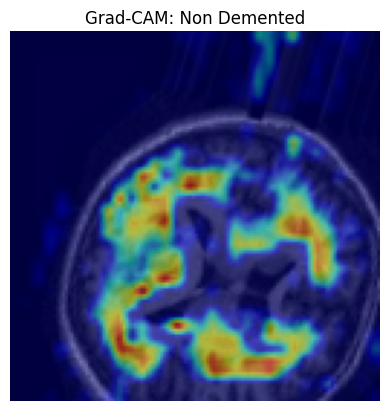

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def grad_cam(model, image, class_idx, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    if grads is None:
        print("Gradient is None. Check the model and inputs.")
        return np.zeros((image.shape[1], image.shape[2]))

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)
    max_val = np.max(heatmap)
    if max_val == 0:
        print("Heatmap is all zeros after ReLU.")
        return np.zeros((image.shape[1], image.shape[2]))

    heatmap /= max_val
    heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))  # No need to call `.numpy()` here
    return heatmap


# Pick one image from validation batch
image_batch, label_batch = next(val_gen)
image_idx = np.random.randint(0, image_batch.shape[0])
image_to_explain = np.expand_dims(image_batch[image_idx], axis=0)

# Predict the class
predicted_class_idx = np.argmax(model.predict(image_to_explain))

# Now compute the Grad-CAM
heatmap = grad_cam(model, image_to_explain, predicted_class_idx, last_conv_layer_name='conv2d_2')

# Show the result
plt.imshow(image_to_explain[0])
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.title(f"Grad-CAM: {idx_to_class[predicted_class_idx]}")
plt.axis('off')
plt.show()


Sailency map

In [ ]:
def saliency_map(model, image, class_idx):
    image_tensor = tf.convert_to_tensor(image)
    image_tensor = tf.cast(image_tensor, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(image_tensor)
        predictions = model(image_tensor, training=False)
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, image_tensor)

    if grads is None:
        print("Gradients are None.")
        return np.zeros((image.shape[1], image.shape[2]))

    # Use absolute gradient magnitude (no ReLU)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

    saliency = saliency.numpy()
    max_val = np.max(saliency)
    if max_val == 0:
        print("Saliency map still all zeros.")
        return np.zeros((image.shape[1], image.shape[2]))

    saliency /= max_val
    return saliency


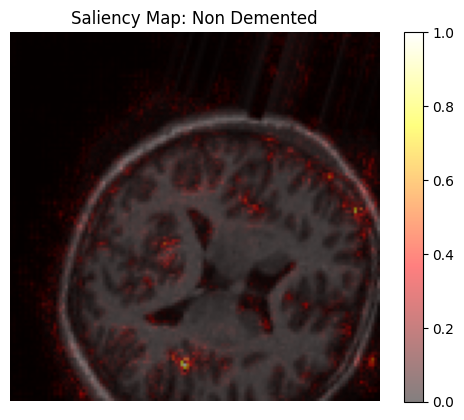

In [ ]:
saliency = saliency_map(model, image_to_explain, predicted_class_idx)

plt.imshow(image_to_explain[0])
plt.imshow(saliency, cmap='hot', alpha=0.5)
plt.title(f"Saliency Map: {idx_to_class[predicted_class_idx]}")
plt.axis('off')
plt.colorbar()
plt.show()